In [1]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import to_categorical
import cv2, numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import applications
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import xml.etree.cElementTree as ET
import os
import pandas as pda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from shutil import copyfile
from pathlib import Path
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1021557824984315594
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 3807934720243907775
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Test InceptionV3

In [28]:
nbClasses = 10
img_rows, img_cols, img_channel = 299, 299, 3

# create the base pre-trained model
base_model = applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(nbClasses, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, None, None, 3 96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, None, None, 3 0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_566

In [29]:
data_path = '/data/test_10classes_EOL/'

training_size = 141
batch_size = 8
epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_path + 'Training/',  
    target_size=(299,299),  
    batch_size=batch_size)  


validation_generator = validation_datagen.flow_from_directory(
        data_path + 'Validation/',
        target_size=(299,299),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
        data_path + 'Test/',
        target_size=(299,299),
        batch_size=batch_size)

history_classif = model.fit_generator(
    train_generator,
    steps_per_epoch= training_size // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint(data_path + 'InceptionV3-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
              
history_conv1 = model.fit_generator(
    train_generator,
    steps_per_epoch= training_size // batch_size,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint(data_path + 'InceptionV3-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
              
history_conv2 = model.fit_generator(
    train_generator,
    steps_per_epoch= training_size // batch_size,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint(data_path + 'InceptionV3-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

model.save_weights('/data/weights/10classes_EOL_InceptionV3.h5')

Found 141 images belonging to 10 classes.
Found 59 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Epoch 1/10
17/17 [==============================] - 93s 5s/step - loss: 5.9757 - acc: 0.2177 - val_loss: 2.4467 - val_acc: 0.2203
Epoch 2/10
17/17 [==============================] - 5s 317ms/step - loss: 2.3626 - acc: 0.1924 - val_loss: 2.8468 - val_acc: 0.2373
Epoch 3/10
17/17 [==============================] - 5s 305ms/step - loss: 2.2899 - acc: 0.1882 - val_loss: 1.7424 - val_acc: 0.4237
Epoch 4/10
17/17 [==============================] - 4s 255ms/step - loss: 2.0393 - acc: 0.3028 - val_loss: 1.8291 - val_acc: 0.3051
Epoch 5/10
17/17 [==============================] - 4s 264ms/step - loss: 1.7679 - acc: 0.3162 - val_loss: 1.9529 - val_acc: 0.2542
Epoch 6/10
17/17 [==============================] - 5s 304ms/step - loss: 1.7873 - acc: 0.3369 - val_loss: 1.5242 - val_acc: 0.5254
Epoch 7/10
17/17 [==============================] - 4s 259ms/step - loss: 1.6240 - acc

In [30]:
test_loss, test_acc = model.evaluate_generator(test_generator)
print('accuracy sur jeu test: ' + str(test_acc))

accuracy sur jeu test: 0.66


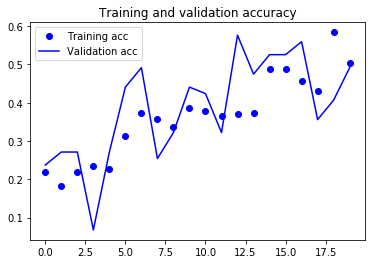

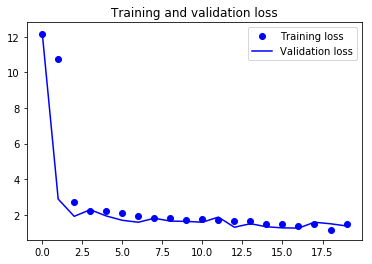

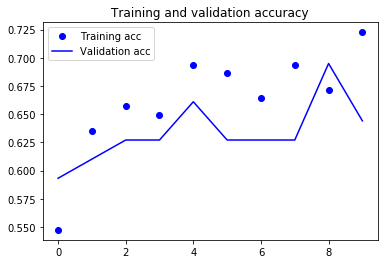

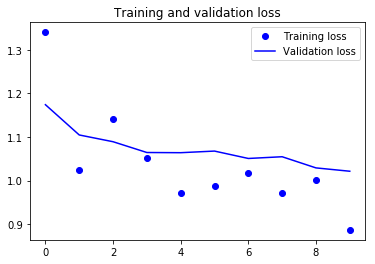

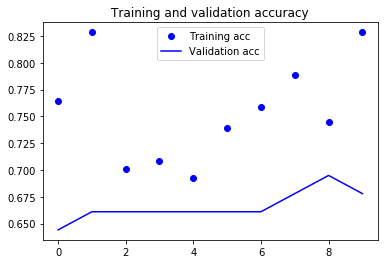

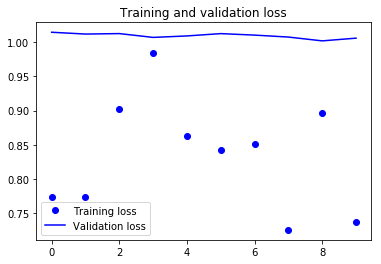

In [21]:
import matplotlib.pyplot as plt

acc = history_classif.history ['acc']
val_acc = history_classif.history['val_acc']
loss = history_classif.history['loss']
val_loss = history_classif.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

import matplotlib.pyplot as plt

acc = history_conv1.history ['acc']
val_acc = history_conv1.history['val_acc']
loss = history_conv1.history['loss']
val_loss = history_conv1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

import matplotlib.pyplot as plt

acc = history_conv2.history ['acc']
val_acc = history_conv2.history['val_acc']
loss = history_conv2.history['loss']
val_loss = history_conv2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()